In [315]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)


use_cuda = torch.cuda.is_available()

! df -k

DATA_ROOT ='/root/data/mnist/'
IMG_DATA_LABELS = DATA_ROOT + '/train.csv'

# classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9', '10')

tensorflow:1.2.1
__Python VERSION: 2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
__pyTorch VERSION: 0.2.0_1
__CUDA VERSION
__CUDNN VERSION: 6021
__Number CUDA Devices: 0
__Devices
Filesystem                                                                1K-blocks       Used  Available Use% Mounted on
none                                                                      516021104  223931312  271019452  46% /
tmpfs                                                                     258004476          0  258004476   0% /dev
tmpfs                                                                     258004476          0  258004476   0% /sys/fs/cgroup
netstore2:/vol/dev_vol/users/skashan/dev/cto-gamma_2472/CTO/data-science 1288490240 1036460160  252030080  81% /root/sharedfolder
netstore2:/vol/CTO_VOL/data                                              6222333888  110079104 6112254784   2% /root/data
/dev/vda1                                                                 516021104  

In [362]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import time 

try:
    from PIL import Image
except ImportError:
    import Image

class GenericImageDataset(Dataset):    
    def __init__(self, csv_path, transform=None):                
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))                
        self.transform=transform
        tmp_df= pd.read_csv(csv_path, dtype=np.float32)
        
        tmp_df.insert(0, 'IMG_ID', range(0, 0 + len(tmp_df)))        
        tmp_df = tmp_df.reset_index(drop=True)
        tmp_df.set_index('IMG_ID', inplace=True, drop=False)
                
        self.X_train = tmp_df[tmp_df.columns[0:786]]                
        lgr.info('[*] Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))

    def __getitem__(self, index):    
        row=self.X_train.loc[[index]] # find the row and return a data frame
        img = row[row.columns[2:786]].values # get only the pixels                       
#         print ("img type:" + str (type(img)))
#         print (("img:" + str (img)))    
        label =row['label'].values[0] # extract mnist label 
#         print ("Label:" + str (type(label)))
#         print (("label:" + str (label)))        
        if self.transform is not None:
            # reshape input image into [batch_size by 784]
#             img = Image.fromarray(numpy.uint8(img))
#             img = Image.fromarray(img, mode='L')
            img = Image.frombytes('L',(28,28),img)
            img = self.transform(img)            
                    
#         lgr.info ("__getitem__:" + str(index) + " Label:" + str(label))
        
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
#         img = np.transpose(img.numpy(), (1, 2, 0))
        img = np.transpose(img.numpy(), (2, 0, 1))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0

In [363]:
transformations=transforms.Compose([ transforms.ToTensor() # first, convert image to PyTorch tensor
#                             transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])

In [364]:
dset_train = GenericImageDataset(IMG_DATA_LABELS, transformations)

INFO:__main__:CSV path /root/data/mnist//train.csv
INFO:__main__:[*] Dataset loading time 5.07674813271
INFO:__main__:[*] Data size is 42000


In [365]:
validationRatio=0.11    
batch_size=4

class FullTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainingDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    
def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    return FullTrainingDataset(dataset, 0, val_offset), FullTrainingDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

TypeError: Invalid dimensions for image data

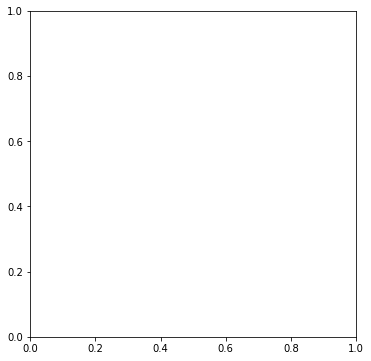

In [367]:
import torchvision 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2, 1, 0)))


# get some random training images
dataiter = iter(val_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
class CNNClassifier(nn.Module):
    """Custom module for a simple convnet classifier"""
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
     
    def forward(self, x):
        # input is 28x28x1
        # conv1(kernel=5, filters=10) 28x28x10 -> 24x24x10
        # max_pool(kernel=2) 24x24x10 -> 12x12x10
         
        # Do not be afraid of F's - those are just functional wrappers for modules form nn package
        # Please, see for yourself - http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
         
        # conv2(kernel=5, filters=20) 12x12x20 -> 8x8x20
        # max_pool(kernel=2) 8x8x20 -> 4x4x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
         
        # flatten 4x4x20 = 320
        x = x.view(-1, 320)
         
        # 320 -> 50
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
         
        # 50 -> 10
        x = self.fc2(x)
         
        # transform to logits
        return F.log_softmax(x)

clf = CNNClassifier()
opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
 
loss_history = []
acc_history = []
 
def train(epoch):
    clf.train() # set model in training mode (need this because of dropout)
     
    # dataset API gives us pythonic batching 
    for batch_id, (data, label) in enumerate(train_loader):
        data = Variable(data)
        target = Variable(label)
         
        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = clf(data)
        loss = F.nll_loss(preds, target)
        loss.backward()
        loss_history.append(loss.data[0])
        opt.step()
         
        if batch_id % 100 == 0:
            print(loss.data[0])
            
def test(epoch):
    clf.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0
     
    for data, target in test_loader:
        data = Variable(data, volatile=True) 
        target = Variable(target)
         
        output = clf(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
 
    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_history.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
for epoch in range(0, 3):
    print("Epoch %d" % epoch)
    train(epoch)
    test(epoch)